/Users/karen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/karen/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


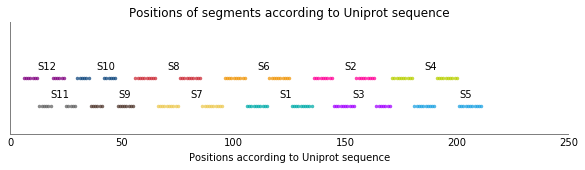

1891 unique mutations across all segments
238 natural unique mutations across all segments
There are 231 single mutations with known effects. They are found in 120 positions


Now the following variables are available:

- data: all data as a (sorted) dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe'

- unique_single_mutations: a dictionary with all single mutations for every segment

- data_singles: a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe' for genotypes containing a single substitution

- single_mut_fitness_dict: a dictionary in the form: 'single mutation' : 'fitness'

- data_known_mutations_only - a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe', 
but only for those genotypes that consist of mutations with known effects (single mutant is measured).
For this dictionary, epistasis is measured for every genotype.



In [1]:
import itertools
import sys
%run 'ks01_Data_import.ipynb'
notebook_prefix = 'ks08'
image_counter = Counter()
from IPython.html.widgets.widget_float import FloatProgress
import matplotlib as mpl
from multiprocessing import Pool

## Epistasis calculated for pairs of mutations based on foursomes: wt >mutA, mutB > mutAB

#### Reading foursomes from files, calculating epistasis and writing it to files

In [2]:
def get_epistasis_values(hdf_file_foursomes, minimal_threshold=20):
    mutA, mutB = hdf_file_foursomes.rstrip('.hdf').split('_')[-3], hdf_file_foursomes.rstrip('.hdf').split('_')[-1]
    if mutA in unique_single_mutations[segment] and mutB in unique_single_mutations[segment]:
        foursome = pd.read_hdf(directory + hdf_file_foursomes, 'data')
        if len(foursome['wild_type']) > minimal_threshold:
            ep = foursome['wild_type']['mut_list_Scer'].apply(lambda wt: foursome_epistasis(foursome, wt))
#             background_fitness = foursome['wild_type']['s']
#             mutA_impacts = foursome['mutA']['s'] - foursome['wild_type']['s']
#             mutB_impacts = foursome['mutB']['s'] - foursome['wild_type']['s']
#             mutAB_impacts = foursome['mutAB']['s'] - foursome['wild_type']['s']
            ep.to_hdf(directory_to_save + hdf_file_foursomes.strip('.hdf') + '--epistasis_values.hdf', 'data')
        else:
            return None

In [3]:
needed = False
if needed:
    for segment in data:
        print segment, '...'
        sys.stdout.flush()
        directory = check_dir('/Users/karen/Downloads/foursomes_full_lib/'+segment.split('_')[0]+'/')
        directory_to_save = check_dir('/Users/karen/Downloads/foursomes_full_lib_epistasis/'+segment.split('_')[0]+'/')
        list_of_files = [f for f in os.listdir(directory) if '.hdf' in f]
        pool = Pool(8)
        pool.map(get_epistasis_values, list_of_files)

## Foursomes individually

In [4]:
needed = True
if needed:
    alpha = 0.4
    wt_color = 'magenta'
    mutA_color = 'green'
    mutB_color = 'orange'

    foursomes_folder = os.path.join(figures_folder, 'foursomes_nat')
    for k,v in ep_dict.items():
        foursome, ep, mutA_impacts, mutB_impacts  = v
        plot_better()
        plt.scatter(foursome['wild_type']['s'].values, ep.values, edgecolor='none', color='black', alpha=0.05);
        title = 'Epistasis in foursomes with mutations %s and %s' %(k[0], k[1])
        plt.title(title + '\nN = %s' %len(foursome['wild_type']))
        plt.axvline(wt_fitness, color=wt_color, alpha=alpha)
        plt.text(0.52, 0.42, 'wild type', color=wt_color, alpha=alpha)
        plt.axhline(0, color='gray', alpha=0.4)

        plt.axvline(wt_fitness + mutA_impacts.median(), color=mutA_color, ls='-', alpha=alpha)
        plt.axvline(wt_fitness + mutB_impacts.median(), color=mutB_color, ls='-', alpha=alpha)

        try:
    #         plt.axvline(single_mut_fitness_dict[k[0]], color=mutA_color, alpha=alpha)
    #         plt.axvline(single_mut_fitness_dict[k[1]], color=mutB_color, alpha=alpha)
            plt.text(0.52, 0.52, 'median impact of %s' % k[0], color=mutA_color, alpha=alpha)
            plt.text(0.52, 0.47, 'median impact of %s' % k[1], color=mutB_color, alpha=alpha)
        except:
            pass
        plt.xlim(0, 0.6)
        plt.ylim(-0.6, 0.6)
        plt.xlabel('Fitness of a "wild type" combination')
        plt.ylabel('Epistasis in a foursome')
        save_image(image_counter, title, foursomes_folder, notebook_prefix)
        plt.close()

### Each position individually

In [5]:
needed = False
if needed:
    colormap = mpl.cm.plasma
    for segment in data:
        positions = sorted(list(set([int(m[:-1]) for m in unique_single_mutations[segment]])))
        for position in positions:
            plot_better()
            already = []
            for mutA, mutB in ep_dict[segment]:
                if str(position) == mutA[:-1] or str(position) == mutB[:-1]:
                    if str(position) == mutA[:-1]:
                        other_position = int(mutB[:-1])
                    if str(position) == mutB[:-1]:
                        other_position = int(mutA[:-1])
                    color_value = int(float(positions.index(other_position)) / len(positions) * 255)
                    color = colormap(color_value)
                    if not other_position in already:
                        plt.scatter(0,0, color=color, label=other_position)
                        already.append(other_position)
                    ep = ep_dict[segment][mutA, mutB][1]
                    if len(ep) > 10:
                        plt.scatter(ep.mean(), ep.std(), alpha=0.8, color=color)
            plt.legend(loc=2, bbox_to_anchor=(1.05, 1), frameon=False)
            plt.axhline(0, color='gray')
            plt.axvline(0, color='gray')
            title = 'Segment %s, pairs with position %s' %(segment.split('_')[0], position)
            plt.title(title)
            plt.xlabel('Mean\nof epistasis values in various backgrounds')
            plt.ylabel('Standard deviation\n of epistasis values in various backgrounds')
        #     save_image(image_counter, title, figures_folder, notebook_prefix)

### Building dictionaries with summary of epistatic interactions

In [6]:
strong_epistasis_threshold = 0.2
folder_with_precalculated_foursomes = '/Users/karen/Downloads/foursomes_full_lib_epistasis/'
minimal_N = 20

#### Reading files

In [7]:
ep_dict = OrderedDict()
for segment in data:
    ep_dict[segment] = {}
    directory =  os.path.join(folder_with_precalculated_foursomes, segment.split('_')[0], '')
    list_of_files = [f for f in os.listdir(directory) if '.hdf' in f]
#     print segment, '(%s files)' %len(list_of_files), '...'
#     sys.stdout.flush()

    for f in list_of_files:
        to_rstrip = '--epistasis_values.hdf'
        mutA, mutB = f.rstrip(to_rstrip).split('_')[-3], f.rstrip(to_rstrip).split('_')[-1]
        ep_dict[segment][mutA, mutB] = pd.read_hdf(directory + f, 'data')

#### Interactions of every position with other positions

In [8]:
def get_empty_segment_position1_position2_defaultdict(segment_mutA_mutB_dict):
    epistasis_by_positions = OrderedDict()
    for segment in segment_mutA_mutB_dict:
        epistasis_by_positions[segment] = OrderedDict()
        mutA_positions = set(mutA[:-1] for mutA, mutB in segment_mutA_mutB_dict[segment])
        mutB_positions = set(mutB[:-1] for mutA, mutB in segment_mutA_mutB_dict[segment])
        all_positions = sorted(list(set.union(mutA_positions, mutB_positions)), key=lambda s: int(s))
        for position1 in all_positions:
            epistasis_by_positions[segment][position1] = OrderedDict()
            for position2 in all_positions:
                if position1 != position2:
                    epistasis_by_positions[segment][position1][position2] = defaultdict(list)
    return epistasis_by_positions

In [9]:
def fill_dictionary_with_values(dict_to_fill, segment_mutA_mutB_dict):
    for segment in segment_mutA_mutB_dict:
        for mutA, mutB in segment_mutA_mutB_dict[segment]:
            posA, posB = mutA[:-1], mutB[:-1]
            ep = segment_mutA_mutB_dict[segment][mutA, mutB]

            if len(ep) > minimal_N:    
                std = ep.std()
                mean = ep.mean()
                fraction_strong = 1. * len(ep[np.abs(ep) > strong_epistasis_threshold]) / len(ep)

                dict_to_fill[segment][posA][posB]['std'].append(std)
                dict_to_fill[segment][posB][posA]['std'].append(std)
                
                dict_to_fill[segment][posA][posB]['mean'].append(mean)
                dict_to_fill[segment][posB][posA]['mean'].append(mean)

                dict_to_fill[segment][posA][posB]['fraction_strong'].append(fraction_strong)
                dict_to_fill[segment][posB][posA]['fraction_strong'].append(fraction_strong)
                
    return dict_to_fill

In [11]:
def filter_segment_position1_position2_dict(segment_position1_position2_dict, what_to_look_at):
    filtered = {}
    for segment in segment_position1_position2_dict:
        filtered[segment] = {}
        for position in segment_position1_position2_dict[segment]:
            other_positions = segment_position1_position2_dict[segment][position].keys()
            other_positions = [p for p in other_positions if len(segment_position1_position2_dict[segment][position][p][what_to_look_at]) > 0]
            values = [np.mean(segment_position1_position2_dict[segment][position][p][what_to_look_at]) for p in other_positions \
                      if len(segment_position1_position2_dict[segment][position][p][what_to_look_at]) > 0]
            filtered[segment][position] = other_positions, values
    return filtered